<center><img src="https://www.americanrivers.org/wp-content/uploads/2016/03/Site-Hero-22.png"></center>


### Introduction

This notebook will illustrate how to implement SimpleRNNs using Keras' functional API. We will also compare the performances of SimpleRNN against that of FNNs for a time series prediction problem.

We will work with a <a href="https://waterdata.usgs.gov/co/nwis/dv/?site_no=09239500&agency_cd=USGS&amp;referred_module=sw
">daily streamflow time series</a> of the <a href="
https://en.wikipedia.org/wiki/Yampa_River
"> Yampa river </a>  in Colorado (US). The Yampa is one of the few free-flowing rivers in the western United States, with only a few small dams and diversions. We want to use neural networks to predict future river flows in a gauging station, i.e., a location used by hydrologists or environmental scientists to monitor and test terrestrial bodies of water. 

<center><img src="https://upload.wikimedia.org/wikipedia/commons/2/22/Brant_Broughton_Gauging_Station_-_geograph.org.uk_-_1057107.jpg" width=400></center>

In this notebook we will also discuss the important differences between 1 step-ahead and multistep-ahead forecasting. We will see that despite the models have good prediction ability for the 1 step-ahead case, performances immediately deteriorate when we increase the prediction horizon. This is expected since the model has no knowledge of the rainfall/snowmelt inputs forcing streamflow. Indeed, in absence of the important inputs, the ANN model learns to essentially replicate the last values of the series. We need to be aware of the limitations of our models and avoid applying them blindly!



#### Link to Google Drive and load modules

In [ ]:
# access my files from Google Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

!ls gdrive

Mounted at /content/gdrive
'My Drive'


In [ ]:
import pandas as pd

# load Yampa dataset
df = pd.read_csv('./gdrive/My Drive/Teaching/CS4305TU Applied Machine Learning/data/Yampa.csv',index_col=0)
df.head()

,streamflow
date,
1988-01-01,67.0
1988-01-02,79.0
1988-01-03,80.0
1988-01-04,72.0
1988-01-05,71.0


In [ ]:
df.tail()

,streamflow
date,
2018-12-27,72.1
2018-12-28,66.1
2018-12-29,65.5
2018-12-30,69.6
2018-12-31,73.7


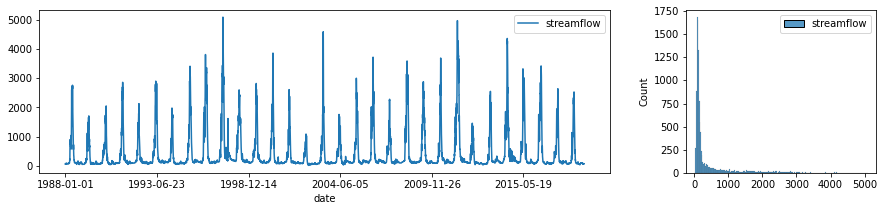

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
import seaborn as sns

# plot data
fig = plt.figure(figsize=(15,3))
spec = gridspec.GridSpec(ncols=2, nrows=1,
                         width_ratios=[3, 1])

ax0 = fig.add_subplot(spec[0])
df.plot(ax=ax0)
ax1 = fig.add_subplot(spec[1])
sns.histplot(df,ax=ax1);

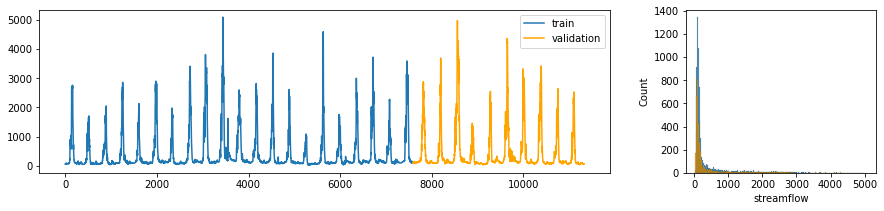

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# dataset split (not random as we are dealing with a time series)
train, test = train_test_split(df.streamflow, test_size=0.33, shuffle=False)

# plot
fig = plt.figure(figsize=(15,3))
spec = gridspec.GridSpec(ncols=2, nrows=1,
                         width_ratios=[3, 1])

ax0 = fig.add_subplot(spec[0])
ax0.plot(np.arange(len(train)),train, label = 'train')
ax0.plot(np.arange(len(train),len(train)+len(test)),test, label='validation', color='orange')
ax0.legend()

ax1 = fig.add_subplot(spec[1])
sns.histplot(train,ax=ax1);
sns.histplot(test,ax=ax1, color='orange');

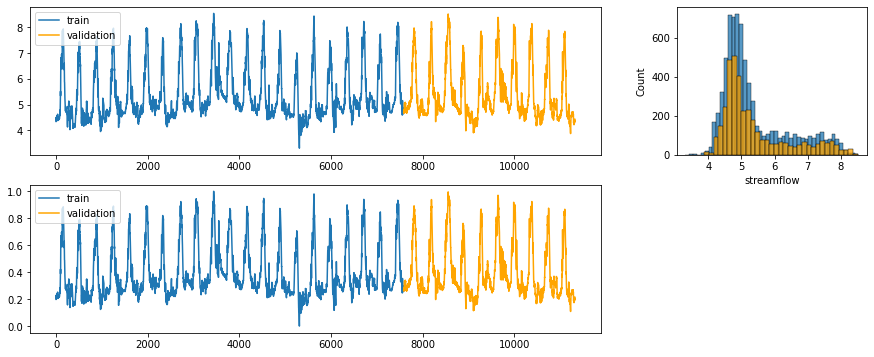

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# log transform
train = np.log(10+train)
test = np.log(10+test)

# plot
fig = plt.figure(figsize=(15,6))
spec = gridspec.GridSpec(ncols=2, nrows=2,
                         width_ratios=[3, 1])



ax0 = fig.add_subplot(spec[0])
ax0.plot(np.arange(len(train)),train, label = 'train')
ax0.plot(np.arange(len(train),len(train)+len(test)),test, label='validation',color='orange')
ax0.legend()

ax1 = fig.add_subplot(spec[1])
sns.histplot(train,ax=ax1)
sns.histplot(test,ax=ax1, color='orange');

# dataset normalization
sc = MinMaxScaler()
train = sc.fit_transform(train.values.reshape(-1,1)) # fit scaler on train dataset and scale train dataset
test = sc.transform(test.values.reshape(-1,1)) # transform test data

ax0 = fig.add_subplot(spec[2])
ax0.plot(np.arange(len(train)),train, label = 'train')
ax0.plot(np.arange(len(train),len(train)+len(test)),test, label='validation',color='orange')
ax0.legend()

#### Craete training and validation datasets

In [ ]:
# function that creates dataset for time-series forecasting application
def create_dateset_timeseries(series, L):  
  X = [] # inputs
  Y = [] # target output

  for t in range(len(series)-L):
    x = series[t:t+L]
    X.append(x)
    y = series[t+L]
    Y.append(y)

  # transform into arrays
  X = np.array(X).reshape(-1,L)
  Y = np.array(Y)
  
  return X,Y

# create datasets using inputs up to 7 days ahead
L = 7

# train dataset
Xtra,Ytra = create_dateset_timeseries(train,L)
Xval,Yval = create_dateset_timeseries(test,L)
print(f"Training: X.shape: {Xtra.shape}, Y.shape: {Ytra.shape}")
print(f"Validation: X.shape: {Xval.shape}, Y.shape: {Yval.shape}")

Training: X.shape: (7579, 7), Y.shape: (7579, 1)
Validation: X.shape: (3730, 7), Y.shape: (3730, 1)


#### Create models and check architectures and weights

In [ ]:
# load keras layers and model modules
from tensorflow.keras.layers import Input, Dense, SimpleRNN, Flatten, Dropout
from tensorflow.keras.models import Model

In [ ]:
H = 3 # number of neurons

# SimpleRNN model
i = Input(shape=(L,1), name='input_layer')
x = SimpleRNN(H, name='recurrent_layer')(i)
x = Dropout(0.1, name='dropout')(x)
x = Dense(1, name='output_layer')(x)
RNN = Model(i,x, name='SimpleRNNmodel')

RNN.summary()

Model: "SimpleRNNmodel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 7, 1)]            0         
_________________________________________________________________
recurrent_layer (SimpleRNN)  (None, 3)                 15        
_________________________________________________________________
dropout (Dropout)            (None, 3)                 0         
_________________________________________________________________
output_layer (Dense)         (None, 1)                 4         
Total params: 19
Trainable params: 19
Non-trainable params: 0
_________________________________________________________________


In [ ]:
for layer in RNN.layers:
  print('_ _ _ '*10)
  print(layer.name)
  for weights in layer.trainable_weights:
    print(f'{weights.name}, \nshape={weights.shape}')

_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
input_layer
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
recurrent_layer
recurrent_layer/simple_rnn_cell/kernel:0, 
shape=(1, 3)
recurrent_layer/simple_rnn_cell/recurrent_kernel:0, 
shape=(3, 3)
recurrent_layer/simple_rnn_cell/bias:0, 
shape=(3,)
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
dropout
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
output_layer
output_layer/kernel:0, 
shape=(3, 1)
output_layer/bias:0, 
shape=(1,)


In [ ]:
# FNN model
i = Input(shape=(L), name='input_layer')
x = Dense(H, name='hidden_layer')(i)
x = Dropout(0.1, name='dropout')(x)
x = Dense(1, name='output_layer')(x)
FNN = Model(i,x, name='FNN')

FNN.summary()

Model: "FNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 7)]               0         
_________________________________________________________________
hidden_layer (Dense)         (None, 3)                 24        
_________________________________________________________________
dropout (Dropout)            (None, 3)                 0         
_________________________________________________________________
output_layer (Dense)         (None, 1)                 4         
Total params: 28
Trainable params: 28
Non-trainable params: 0
_________________________________________________________________


In [ ]:
for layer in FNN.layers:
  print('_ _ _ '*10)
  print(layer.name)
  for weights in layer.trainable_weights:
    print(f'{weights.name}, \nshape={weights.shape}')

_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
input_layer
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
hidden_layer
hidden_layer/kernel:0, 
shape=(7, 3)
hidden_layer/bias:0, 
shape=(3,)
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
dropout
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
output_layer
output_layer/kernel:0, 
shape=(3, 1)
output_layer/bias:0, 
shape=(1,)


#### Train models

In [ ]:
# load keras optimizers and callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler


In [ ]:
# scheduler
import tensorflow as tf
def scheduler(epoch, lr):
  if epoch%25==0:
    lr = 0.001
  else:
    lr = lr * tf.math.exp(-0.1)
  return lr

In [ ]:
# SimpleRNN
RNN.compile(loss='mse',optimizer=Adam(lr=0.001), metrics=['mae'])

# early stopping callback to prevent overfitting
earlyStopping= EarlyStopping(monitor='val_loss', patience=5, mode='auto', verbose=1, restore_best_weights=True)
lrScheduler = LearningRateScheduler(scheduler)

# train
rRNN = RNN.fit(Xtra, Ytra, epochs=200, validation_data = (Xval, Yval), verbose=0, callbacks=[earlyStopping,lrScheduler])

Restoring model weights from the end of the best epoch.
Epoch 00070: early stopping


In [ ]:
# FNN
FNN.compile(loss='mse',optimizer=Adam(lr=0.0001), metrics=['mae'])

# early stopping callback to prevent overfitting
earlyStopping= EarlyStopping(monitor='val_loss', patience=5, mode='auto', verbose=1, restore_best_weights=True)
lrScheduler = LearningRateScheduler(scheduler)

# train
rFNN = FNN.fit(Xtra, Ytra, epochs=100, validation_data = (Xval, Yval), verbose=0, callbacks=[earlyStopping,lrScheduler])

Restoring model weights from the end of the best epoch.
Epoch 00073: early stopping


#### Compare the two models

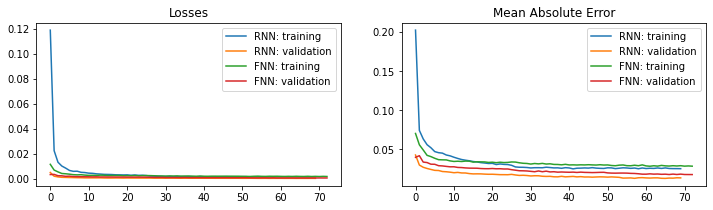

In [ ]:
# setup plots
f, axes = plt.subplots(1,2,figsize=(12,3))

# plot loss
axes[0].plot(rRNN.history['loss'], label ='RNN: training')
axes[0].plot(rRNN.history['val_loss'], label ='RNN: validation')
axes[0].plot(rFNN.history['loss'], label ='FNN: training')
axes[0].plot(rFNN.history['val_loss'], label ='FNN: validation')
axes[0].set_title('Losses');
axes[0].legend();

# plot loss
axes[1].plot(rRNN.history['mae'], label ='RNN: training')
axes[1].plot(rRNN.history['val_mae'], label ='RNN: validation')
axes[1].plot(rFNN.history['mae'], label ='FNN: training')
axes[1].plot(rFNN.history['val_mae'], label ='FNN: validation')
axes[1].set_title('Mean Absolute Error');
axes[1].legend();

In [ ]:
print(f"RNN mae: {np.array(rRNN.history['val_mae']).min():.6f}")
print(f"FNN mae: {np.array(rFNN.history['val_mae']).min():.6f}")

RNN mae: 0.012603
FNN mae: 0.017488


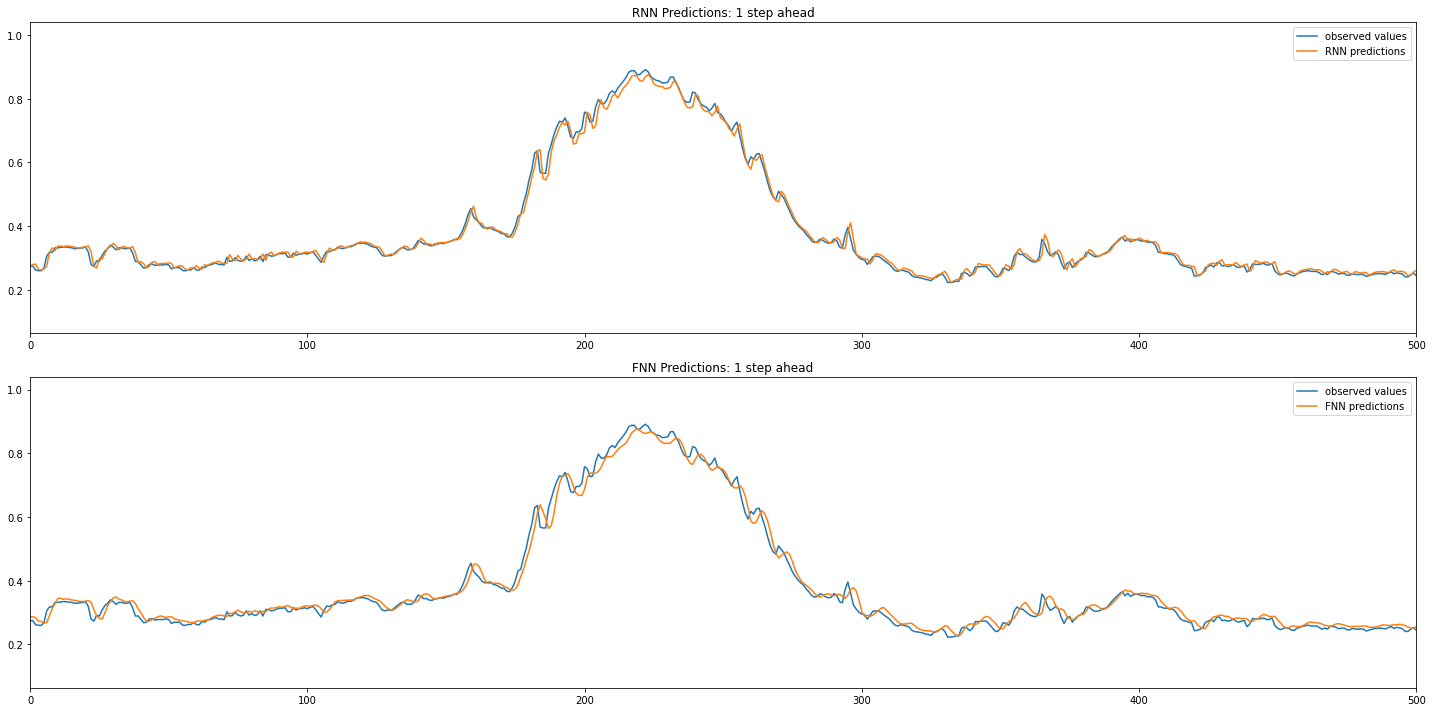

In [ ]:
# setup plots
f, axes = plt.subplots(2,1,figsize=(20,10))

# predict (1 step ahead)
RNN_val_pred = RNN.predict(Xval)
FNN_val_pred = FNN.predict(Xval)

# plot predictions
axes[0].plot(Yval, label='observed values')
axes[0].plot(RNN_val_pred, label='RNN predictions')
axes[0].set_title('RNN Predictions: 1 step ahead')
axes[0].set_xlim([0,500])
axes[0].legend()
# plot predictions
axes[1].plot(Yval, label='observed values')
axes[1].plot(FNN_val_pred, label='FNN predictions')
axes[1].set_title('FNN Predictions: 1 step ahead')
axes[1].set_xlim([0,500])
axes[1].legend()
f.tight_layout()

#### Multistep-head forecasting

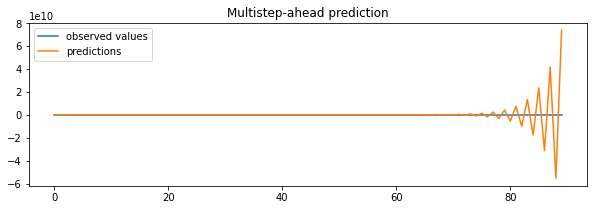

In [ ]:
# multi step ahead predictions on validation
validation_target = Yval[:90]
validation_predictions = []

last_x = Xval[0]

while len(validation_predictions) < len(validation_target):
  p = FNN.predict(last_x.reshape(1,-1))[0,0]

  # update the predictions list
  validation_predictions.append(p)

  last_x = np.roll(last_x,-1)
  last_x[-1] = p

f, ax = plt.subplots(1, figsize=(10,3))
ax.plot(validation_target, label='observed values')
ax.plot(validation_predictions, label='predictions')
ax.set_title('Multistep-ahead prediction')
ax.legend();

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8086d0d4-4bcd-4dff-b47c-0b35edb81aeb' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>